In [1]:
import numpy as np
import pandas as pd
from IPython.display import HTML
import math

from collab2.foraging.toolkit import (
    _add_velocity,
    _generic_velocity_predictor,
    _velocity_predictor_contribution,
    animate_predictors,
    dataObject,
    generate_local_windows,
    generate_pairwiseCopying,
    plot_predictor,
    rescale_to_grid,
    subsample_frames_constant_frame_rate,
)

In [2]:
# create a test object with random data
num_frames = 8
num_foragers = 4
grid_size = 30
n_nans = int(num_frames * num_foragers / 5)
n_missing = int(num_frames * num_foragers / 5)
gridMin = -1
gridMax = 1

np.random.seed(42)

# generate data in a unit disk
theta = 2 * np.pi * np.random.rand(num_frames * num_foragers)
r = np.random.rand(num_frames * num_foragers)

data = {
    "x": r * np.cos(theta),
    "y": r * np.sin(theta),
    "time": np.tile(np.arange(num_frames), num_foragers),
    "forager": np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)]),
}

foragersDF = pd.DataFrame(data)

# # add nan values
# nan_ind = np.random.randint(0, num_frames * num_foragers, size=n_nans)
# foragersDF.loc[nan_ind, ["x", "y"]] = np.nan

# # remove values for certain time points
# drop_ind = np.random.randint(0, num_frames * num_foragers, size=n_missing)
# foragersDF = foragersDF.drop(drop_ind)

# scaling and subsampling
foragersDF_scaled = rescale_to_grid(
    foragersDF, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
foragers_object = dataObject(foragersDF_scaled, grid_size=grid_size, frames=num_frames)

In [3]:
# get local windows
local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

In [4]:
def proximity_scoring_function(distance: float, getting_worse: float = 1.5, optimal: float =4, proximity_decay: float =1):
    if distance <= getting_worse:
        return math.sin(math.pi / (2 * getting_worse) * (distance + 3 * getting_worse))
    elif distance <= getting_worse + 1.5 * (optimal - getting_worse):
        return math.sin(
            math.pi / (2 * (optimal - getting_worse)) * (distance - getting_worse)
        )
    else:
        return math.sin(
            math.pi
            / (2 * (optimal - getting_worse))
            * (1.5 * (optimal - getting_worse))
        ) * math.exp(1) ** (
            -proximity_decay * (distance - optimal - 0.5 * (optimal - getting_worse))
        )

In [5]:
# proximity_predictor_contribution for a test case
test_pred = [[None for i in range(num_frames)] for j in range(num_foragers)]

# compute the predictor contribution for a random case
f = 3
t = 3
x = foragers_object.foragers[f].loc[t, "x"]
y = foragers_object.foragers[f].loc[t, "y"]

print(f,2,x,y)

3 2 10.0 14.0


In [6]:
def _proximity_predictor_contribution(
    x_other: int,
    y_other: int,
    grid: pd.DataFrame,
    getting_worse: float,
    optimal: float,
    proximity_decay: float,
) -> np.ndarray:

    print(grid.shape)
    distance_to_other = np.sqrt((grid["x"] - x_other) ** 2 + (grid["y"] - y_other) ** 2)
    proximity_score = np.vectorize(proximity_scoring_function)(distance_to_other, getting_worse, optimal, proximity_decay)
    return proximity_score

proximity_1 = _proximity_predictor_contribution(x_other = 13, y_other = 14, 
                                  grid = local_windows[f][t],
                                  getting_worse = 1.5,
                                  optimal = 4,
                                  proximity_decay = 1)

proximity_2 = _proximity_predictor_contribution(x_other = 8, y_other = 7,
                                    grid = local_windows[f][t],
                                    getting_worse = 1.5,
                                    optimal = 4,
                                    proximity_decay = 1)

# additive combination
test_pred[f][t] = local_windows[f][t].copy()
test_pred[f][t]["proximity"] = (proximity_1 + proximity_2)


(317, 5)
(317, 5)


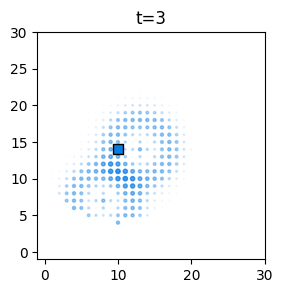

In [7]:
plot_predictor(
    foragers_object.foragers,
    test_pred,
    "proximity",
    [f],
    [t],
    grid_size,
    size_multiplier=10,
    random_state=10,
)

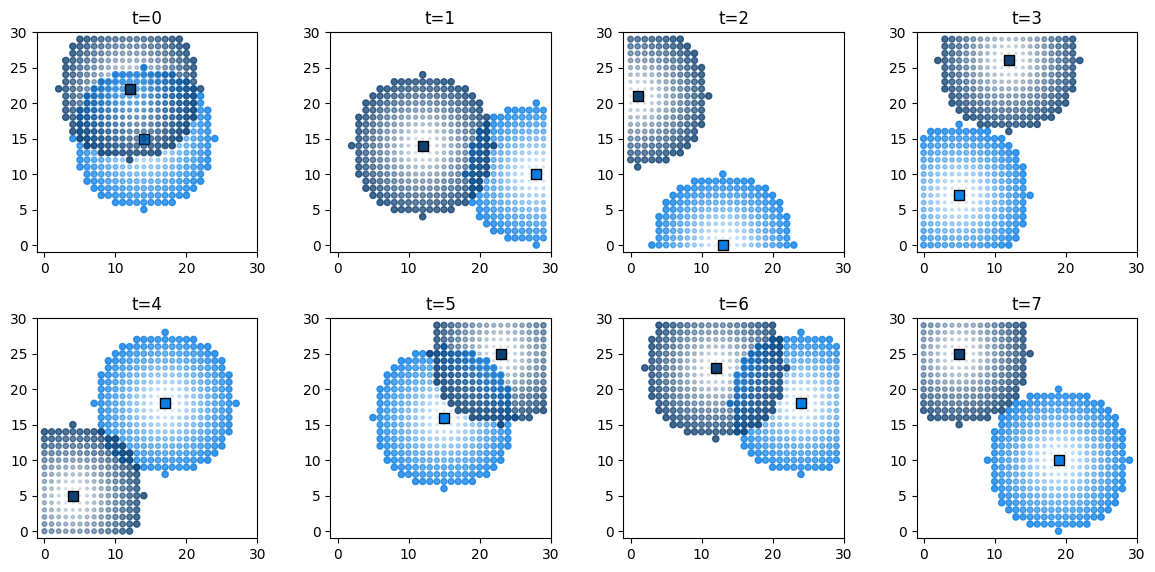

In [4]:
plot_predictor(
    foragers_object.foragers,
    local_windows,
    predictorID="distance_to_f",
    forager_index=[0, 2],
    time=range(num_frames),
    grid_size=grid_size,
    size_multiplier=20,
    random_state=10,  # selects the plot colors
)